# Beschreiben und visualisieren der Daten

In diesem Notebook werden die Datensätze, welche im Notebook "Laden der Daten" aufbereitet wurden, statistisch beschrieben und graphisch visualisiert. Aus den gewonnenen Erkenntnissen werden mögliche Massnahmen für die Reduzierung der Fahrradunfälle abgeleitet.

***
# Installation notwenidger Bibliotheken

In [2]:
!pip install folium
!pip install geopandas
!pip install wordcloud
# !pip install --user matplotlib==3.3.4

***
# Module importieren

In [1]:
!pip install jupyter-tabnine
!jupyter nbextension install --py jupyter_tabnine
!jupyter nbextension enable --py jupyter_tabnine
!jupyter serverextension enable --py jupyter_tabnine



Installing /opt/conda/lib/python3.10/site-packages/jupyter_tabnine/static -> jupyter_tabnine
Traceback (most recent call last):
  File "/opt/conda/bin/jupyter-nbextension", line 10, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/jupyter_core/application.py", line 277, in launch_instance
    return super().launch_instance(argv=argv, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.10/site-packages/notebook/nbextensions.py", line 972, in start
    super().start()
  File "/opt/conda/lib/python3.10/site-packages/jupyter_core/application.py", line 266, in start
    self.subapp.start()
  File "/opt/conda/lib/python3.10/site-packages/notebook/nbextensions.py", line 702, in start
    self.install_extensions()
  File "/opt/conda/lib/python3.10/site-packages/notebook/nbextensions.py", line 675, in install_extensions
    full_dests = install(sel

In [4]:
# Import base libs
import csv
import calendar
from shapely import wkt
from IPython.display import Video

# Matplotlib and associated plotting modules
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# library to handle data in a vectorized manner 
import numpy as np 

# library for data analsysis
import pandas as pd
import geopandas as gpd

# Use Folium to display the Maps for Visualisation
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

print('Libraries imported.')

Libraries imported.


Matplotlib Version prüfen. Für den bar_char_race weiter unten im Notbook wird die Version 3.2.2 benötigt.

In [5]:
print(matplotlib.__version__)

3.6.3


***
# Funktionen

Letzter Zugriff: 30.11.2021 https://stackoverflow.com/questions/37751120/restart-ipython-kernel-with-a-command-from-a-cell

In [6]:
from IPython.core.display import HTML

In [7]:
def restartkernel():
    HTML("<script>Jupyter.notebook.kernel.restart()</script>")

#### Breiten- und Längengrad von Zürich

In [6]:
def koordinaten_zh():
    address = 'Zurich, CH'
    geolocator = Nominatim(user_agent="Jupyter")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

***
# Beschreibung der Fahrradunfälle

In den Datensätzen werden die Unfälle auf 11 unterschiedlichen Arten beschrieben. Die Häufigkeitsverteilung soll mithilfe der Wordcloud dargestellt werden.

In [7]:
df_unfaelle = pd.read_csv('./Daten/velounfaelle_2019_ZH.csv',sep=';')

In [8]:
AccidentExpl = df_unfaelle.groupby('AccidentExpl')

In [9]:
df_new = AccidentExpl.count().sort_values(by='AccidentYear',ascending=False)
df_new.drop(df_new.iloc[:,1:12], axis=1, inplace=True)
df_new.reset_index(inplace=True)

In [10]:
d = dict(zip(df_new.AccidentExpl,df_new.AccidentSeverityCategory))

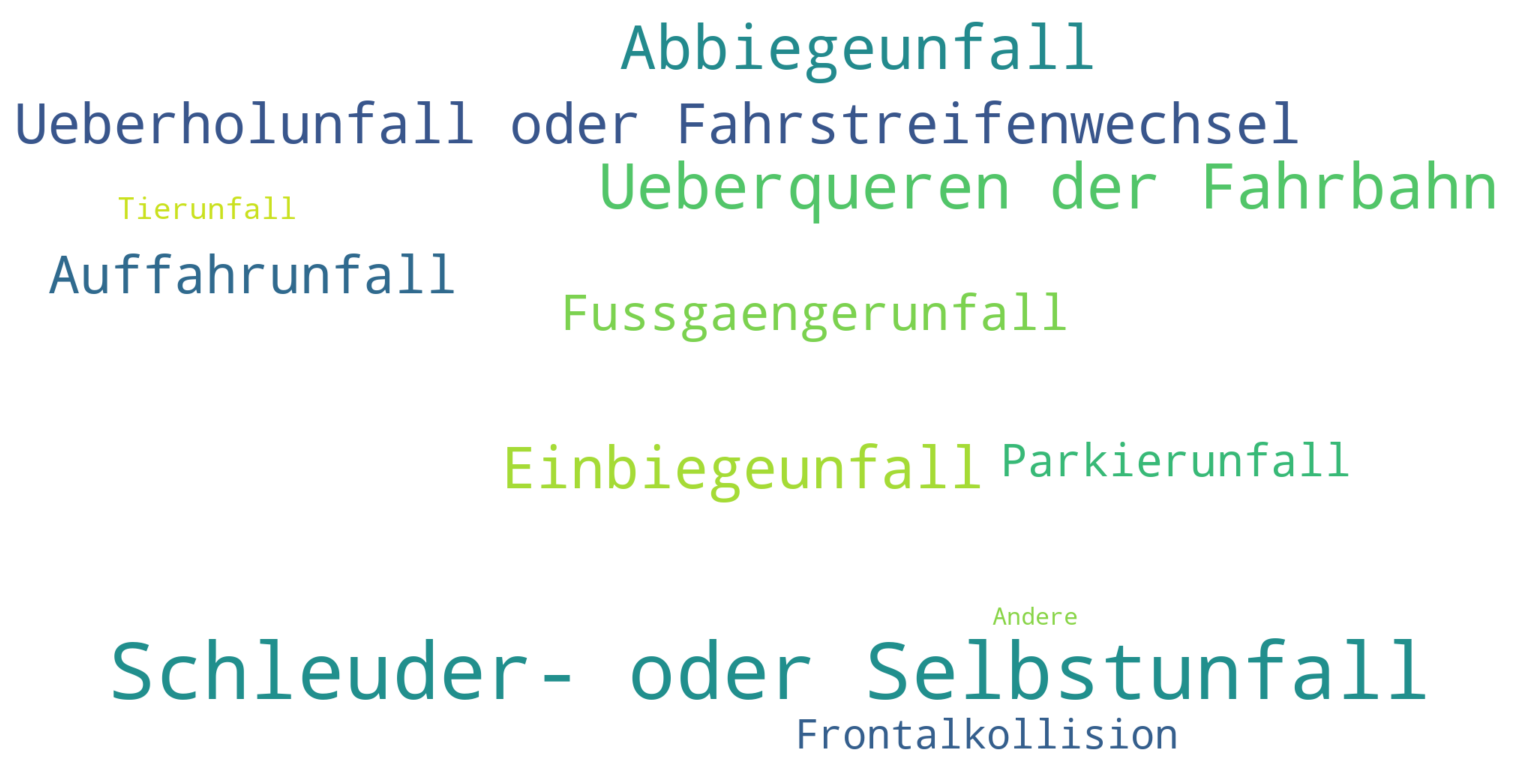

In [11]:
wordcloud = WordCloud(width = 2000, height = 1000,background_color="white",collocations=False, relative_scaling=0.3).generate_from_frequencies(d)
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
wordcloud.to_file('./Image/wordcloud.png')

***
# Velounfälle Hotspots Stadt ZH Jahr 2019

Letzter Zufgriff: 30.11.2021 https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-data/notebook

In [12]:
df_unfaelle = pd.read_csv('./Daten/velounfaelle_2019_ZH.csv',sep=';')

In [13]:
heat_df = df_unfaelle[['Latidute_wgs84', 'Longitude_wgs84']]

In [14]:
# List comprehension to make out list of lists
heat_data = [[row['Latidute_wgs84'], row['Longitude_wgs84']] for index, row in heat_df.iterrows()]

In [15]:
# mail von Maurizio, 24.11.21, workaround for SSL Error:
import ssl
import certifi
import geopy.geocoders
ctx = ssl.create_default_context(cafile=certifi.where())
geopy.geocoders.options.default_ssl_context = ctx
print(certifi.where())

/opt/conda/lib/python3.10/site-packages/certifi/cacert.pem


In [16]:
# Koordinaten von ZH ermitteln und folium.Map hinzufügen
koor_zh = koordinaten_zh()

m = folium.Map(location=[koor_zh[0], koor_zh[1]],zoom_start=12)

incidents = plugins.MarkerCluster().add_to(m)

for lat, lng, label, in zip(df_unfaelle.Latidute_wgs84, df_unfaelle.Longitude_wgs84, df_unfaelle.AccidentSeverityCategory):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

HeatMap(heat_data,
        min_opacity=1,
        max_zoom=18,  
        radius=22,
        blur=34,
        gradient=None,
        overlay=True).add_to(m)

m.save('./Image/heatmap_zh.html')
m

***
# Darstellung der Unfälle pro Monat

Es soll die Unfallhäufigkeit im Jahr 2019 betrachtet werden. Zuerst werden in einer "Heatmap with time series" die Unfall-Hotspots pro Monat dargestellt. In der Karte kann über die "Time-Bar" oder über die (Forward/Backward)-Buttons einen einzelnen Monat dargestellt werden. Für die Detailansicht steht die Zoom-In and -Out Funktion zur Verfügung. Beim Ausführen der Zelle startet die Kartenanimation automatisch. Die Karte wird anschliessend als html Format abgespeichert und kann jederzeit im Internet Browser angeschaut werden. In einem zweiten Schritt werden die absoluten Unfallzahlen pro Monat in einem Bar chart dargestellt. Der Chart wird als png-File lokal gespeichert.

In [17]:
df_unfaelle = pd.read_csv('./Daten/velounfaelle_2019_ZH.csv',sep=';')

In [18]:
heat_df_month = df_unfaelle[['Latidute_wgs84', 'Longitude_wgs84','AccidentMonth']]

Letzter Zugriff: 30.11.2021 https://www.kaggle.com/daveianhickey/how-to-folium-for-maps-heatmaps-time-analysis

In [19]:
# List comprehension to make out list of lists
heat_data_month = [[[row['Latidute_wgs84'], row['Longitude_wgs84']] for index, row in heat_df_month[heat_df_month['AccidentMonth'] == i].iterrows()] for i in range(1,13)]

In [20]:
# Koordinaten von ZH ermitteln und folium.Map hinzufügen
koor_zh = koordinaten_zh()
m_month = folium.Map(location=[koor_zh[0], koor_zh[1]],zoom_start=12)

In [21]:
# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data_month,auto_play=True, max_opacity=0.8)
hm.add_to(m_month)

In [22]:
m_month.save('./Image/heatmap_unfaelle_monat.html')
display(m_month)

In [23]:
# Monat Nummer zu Monat Name konvertieren und als zusätzliche Spalte hinzufügen
df_unfaelle['month_name'] = df_unfaelle['AccidentMonth'].apply(lambda x: calendar.month_name[x])

In [24]:
# Farbe für jeden Monat / Verwendung für den Bar chart
clist = [(0, "darkgreen"), (0.125, "green"), (0.25, "red"), (0.5, "blue"), 
         (0.7, "darkblue"), (0.75, "red"), (1, "darkred")]

rvb = colors.LinearSegmentedColormap.from_list("", clist)

N = 24
x = np.arange(N).astype(float)

Letzter Zugriff: 30.11.2021 https://matplotlib.org/stable/gallery/lines_bars_and_markers/hat_graph.html#sphx-glr-gallery-lines-bars-and-markers-hat-graph-py

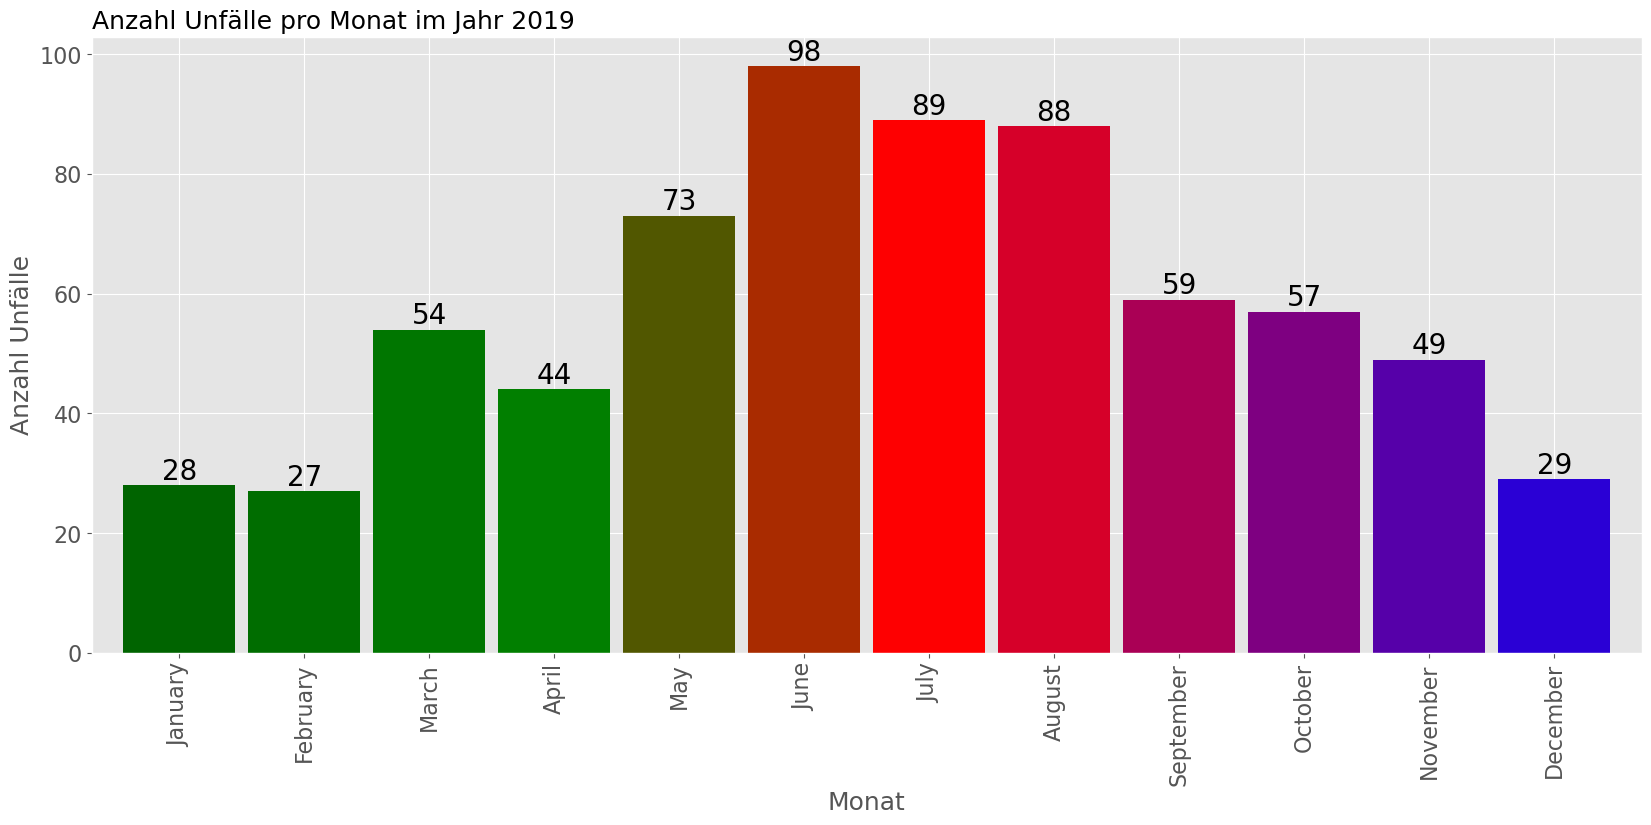

In [25]:
#Bar chart style setzen
matplotlib.style.use('ggplot')

#X-Achsen Beschriftung
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

# Unfälle nach Monat gruppieren und bar chart erstellen
fig = df_unfaelle.groupby([df_unfaelle['AccidentMonth']], sort=True).count().plot(y = 'month_name', 
                                                                                  kind ='bar',
                                                                                  figsize = (20,8),
                                                                                  width = 0.9,
                                                                                  color = rvb(x/N))
plt.rcParams.update({'font.size': 20})

# main axes
ax = fig.axes
ax.set_xticklabels(months)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

    
for p in ax.patches:                 
    ax.annotate(np.round(p.get_height(),decimals=2),                             
    (p.get_x() + p.get_width() / 2, p.get_height()),                              
    ha='center',                              
    va='center',                              
    xytext=(0, 10),                               
    textcoords='offset points')


plt.xlabel('Monat', fontsize=18)
plt.ylabel('Anzahl Unfälle', fontsize=18)
plt.title('Anzahl Unfälle pro Monat im Jahr 2019', loc='left', fontsize=18)
leg = ax.legend(prop={"size":16})
ax.get_legend().remove()

plt.savefig('./Image/unfaelle_monat_zh.png', bbox_inches='tight')
plt.show()

***
# Darstellung der Unfälle pro Stunde

Mit den geleichen Methoden wie im vorhergehenden Kapitel, wird in diesem Kapitel die Unfallhäufigkeit pro Stunde analysiert.  Die Karte wird anschliessend als html Format abgespeichert und kann jederzeit im Internet Browser angeschaut werden. Der Bar chart wird als png-File lokal gespeichert.

In [26]:
df_unfaelle = pd.read_csv('./Daten/velounfaelle_2019_ZH.csv',sep=';')

In [27]:
heat_df_hour = df_unfaelle[['Latidute_wgs84', 'Longitude_wgs84', 'AccidentHour']]

In [28]:
heat_data_hour = [[[row['Latidute_wgs84'], row['Longitude_wgs84']] for index, row in heat_df_hour[heat_df_hour['AccidentHour'] == i].iterrows()] for i in range(0,23)]

In [29]:
# Koordinaten von ZH ermitteln und folium.Map hinzufügen
koor_zh = koordinaten_zh()
m_hour = folium.Map(location=[koor_zh[0], koor_zh[1]],zoom_start=12)

In [30]:
# Plot it on the map
hm = plugins.HeatMapWithTime(heat_data_hour,auto_play=True,max_opacity=0.8)
hm.add_to(m_hour)

In [31]:
m_month.save('./Image/heatmap_unfaelle_stunde.html')
display(m_hour)

In [32]:
# Farbe für jede Stunde/ Verwendung für den Bar chart
clist = [(0, "darkgreen"), (0.125, "green"), (0.25, "red"), (0.5, "blue"), 
         (0.7, "darkblue"), (0.75, "red"), (1, "darkred")]

rvb = colors.LinearSegmentedColormap.from_list("", clist)

N = 48
x = np.arange(N).astype(float)

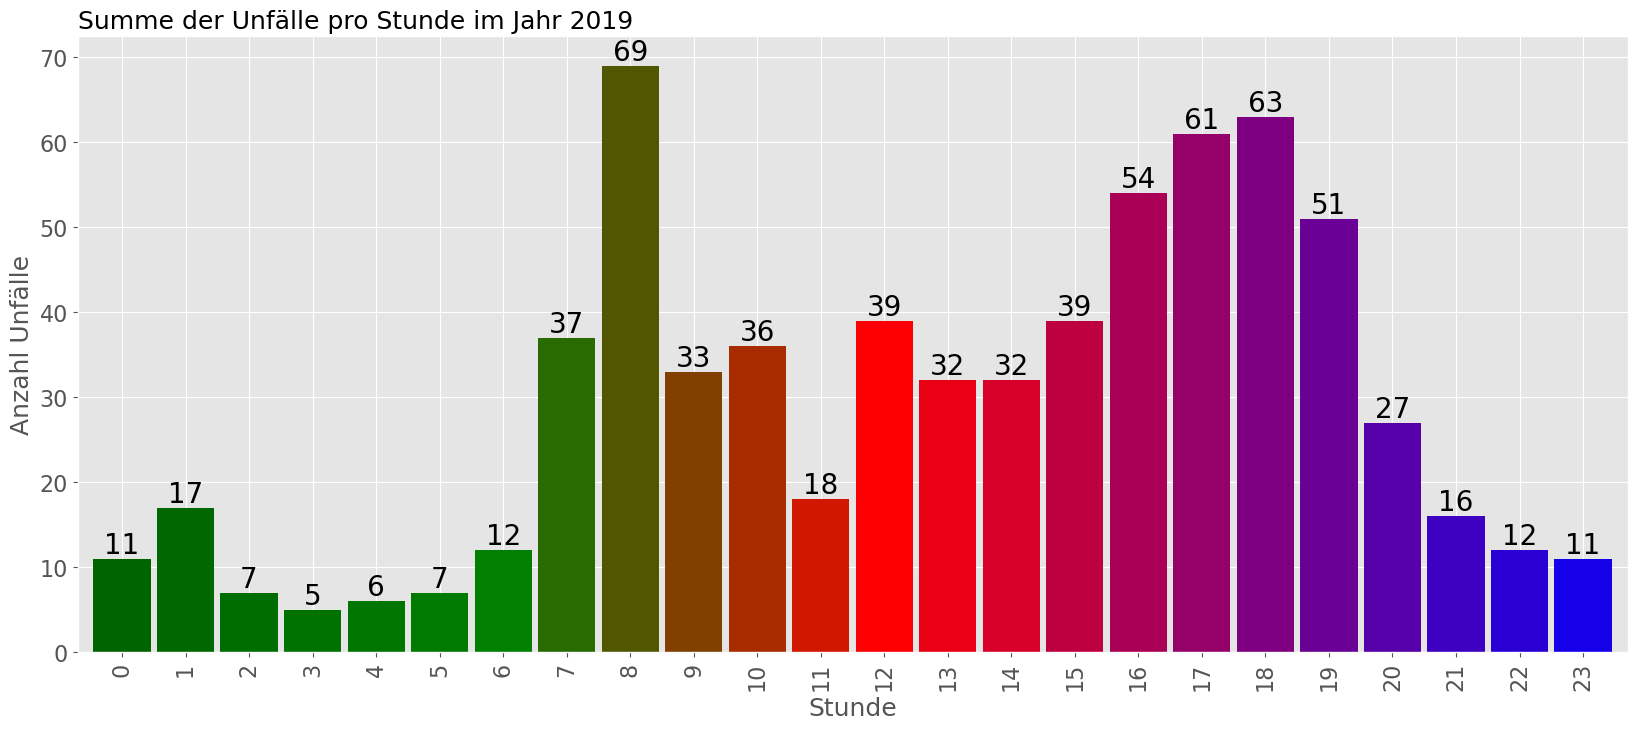

In [33]:
#Bar chart style setzen
matplotlib.style.use('ggplot')

#X-Achsen Beschriftung
hours = range(0,24)

# Unfälle nach Monat gruppieren und bar chart erstellen
fig = df_unfaelle.groupby([df_unfaelle['AccidentHour']], sort=True).count().plot(y = 'AccidentExpl', 
                                                                                  kind ='bar',
                                                                                  figsize = (20,8),
                                                                                  width = 0.9,
                                                                                  color = rvb(x/N))
plt.rcParams.update({'font.size': 20})

# main axes
ax = fig.axes
ax.set_xticklabels(hours)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)

    
for p in ax.patches:                 
    ax.annotate(np.round(p.get_height(),decimals=2),                             
    (p.get_x() + p.get_width() / 2, p.get_height()),                              
    ha='center',                              
    va='center',                              
    xytext=(0, 10),                               
    textcoords='offset points')


plt.xlabel('Stunde', fontsize=18)
plt.ylabel('Anzahl Unfälle', fontsize=18)
plt.title('Summe der Unfälle pro Stunde im Jahr 2019', loc='left', fontsize=18)
leg = ax.legend(prop={"size":16})
ax.get_legend().remove()

plt.savefig('./Image/unfaelle_Stunde_zh.png', bbox_inches='tight')
plt.show()

***
# Darstellung der Unfälle nach Schweregrad

In diesem Abschnitt werden die Unfallstandorte nach den Top 2 Unfallschweregrad ("Getötet, Schwerverletzte) in einer Karte visualisiert. Auch hier steht für die Detailansicht  die Zoom-In and -Out Funktion zur Verfügung. Aufgrund der Anzahl Unfälle mit Schwerverletzten wird in einer zweiten Karte diese Kategorie gruppiert angezeigt und die Unfälle mit verstorbenen einzeln dargestellt. Beider Karten werden als html Datei lokal gespeichert.

In [34]:
df_unfaelle = pd.read_csv('./Daten/velounfaelle_2019_ZH.csv',sep=';')

In [35]:
df_getötete = df_unfaelle[df_unfaelle.AccidentSeverityCategory == 'Unfall mit Getöteten']

In [36]:
df_schwerver = df_unfaelle[df_unfaelle.AccidentSeverityCategory == 'Unfall mit Schwerverletzten']

Letzter Zugriff: 30.11.2021 https://getbootstrap.com/docs/3.3/components/#glyphicons

In [37]:
# Koordinaten von ZH ermitteln und folium.Map hinzufügen
koor_zh = koordinaten_zh()
map = folium.Map(location=[koor_zh[0], koor_zh[1]],zoom_start=12)

for lat, lng, label, in zip(df_getötete.Latidute_wgs84, df_getötete.Longitude_wgs84, df_getötete.AccidentSeverityCategory):
    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(color='red',
                         icon_color='white',
                         icon='remove',     
                         prefix='glyphicon'),
        popup=label,
    ).add_to(map)
    
for lat, lng, label, in zip(df_schwerver.Latidute_wgs84, df_schwerver.Longitude_wgs84, df_schwerver.AccidentSeverityCategory):
    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(color='white',
                         icon_color='red',
                         icon='plus',     
                         prefix='glyphicon'),
        popup=label,
    ).add_to(map)

map.save('./Image/schwerverletzte.html')
map

In [38]:
# Koordinaten von ZH ermitteln und folium.Map hinzufügen
koor_zh = koordinaten_zh()
map = folium.Map(location=[koor_zh[0], koor_zh[1]],zoom_start=12)

incidents = plugins.MarkerCluster().add_to(map)

for lat, lng, label, in zip(df_getötete.Latidute_wgs84, df_getötete.Longitude_wgs84, df_getötete.AccidentSeverityCategory):
    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(color='red',
                         icon_color='white',
                         icon='remove',     
                         prefix='glyphicon'),
        popup=label,
    ).add_to(map)
    
for lat, lng, label, in zip(df_schwerver.Latidute_wgs84, df_schwerver.Longitude_wgs84, df_schwerver.AccidentSeverityCategory):
    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(color='white',
                         icon_color='red',
                         icon='plus',     
                         prefix='glyphicon'),
        popup=label,
    ).add_to(incidents)
    
map.save('./Image/verschtorben.html')
map

# Häufigkeitsverteilung der Unfälle nach Beschreibung, Schweregrad und Strassenart

Die Anzahl Unfälle pro Monat werden in diesem Kapitel detaillierter analysiert. Betrachtet werden 3 Häufigkeitsverteilungen mit den Kategorien: Unfallbeschreibung, Unfallschweregrad und Unfälle nach Strassenart. Die Bar charts werden anschliessend als png-File lokal gespeichert. 

In [39]:
df_unfaelle['month_name'] = df_unfaelle['AccidentMonth'].apply(lambda x: calendar.month_name[x])
df_unfaelle_rel = df_unfaelle[['AccidentExpl','AccidentSeverityCategory', 'RoadType', 'month_name']]

In [40]:
gb_expl = df_unfaelle.groupby(['month_name','AccidentExpl'], sort=False, as_index=False).size()
gb_cat = df_unfaelle.groupby(['month_name','AccidentSeverityCategory'], sort=False, as_index=False).size()
gb_road = df_unfaelle.groupby(['month_name','RoadType'], sort=False, as_index=False).size()

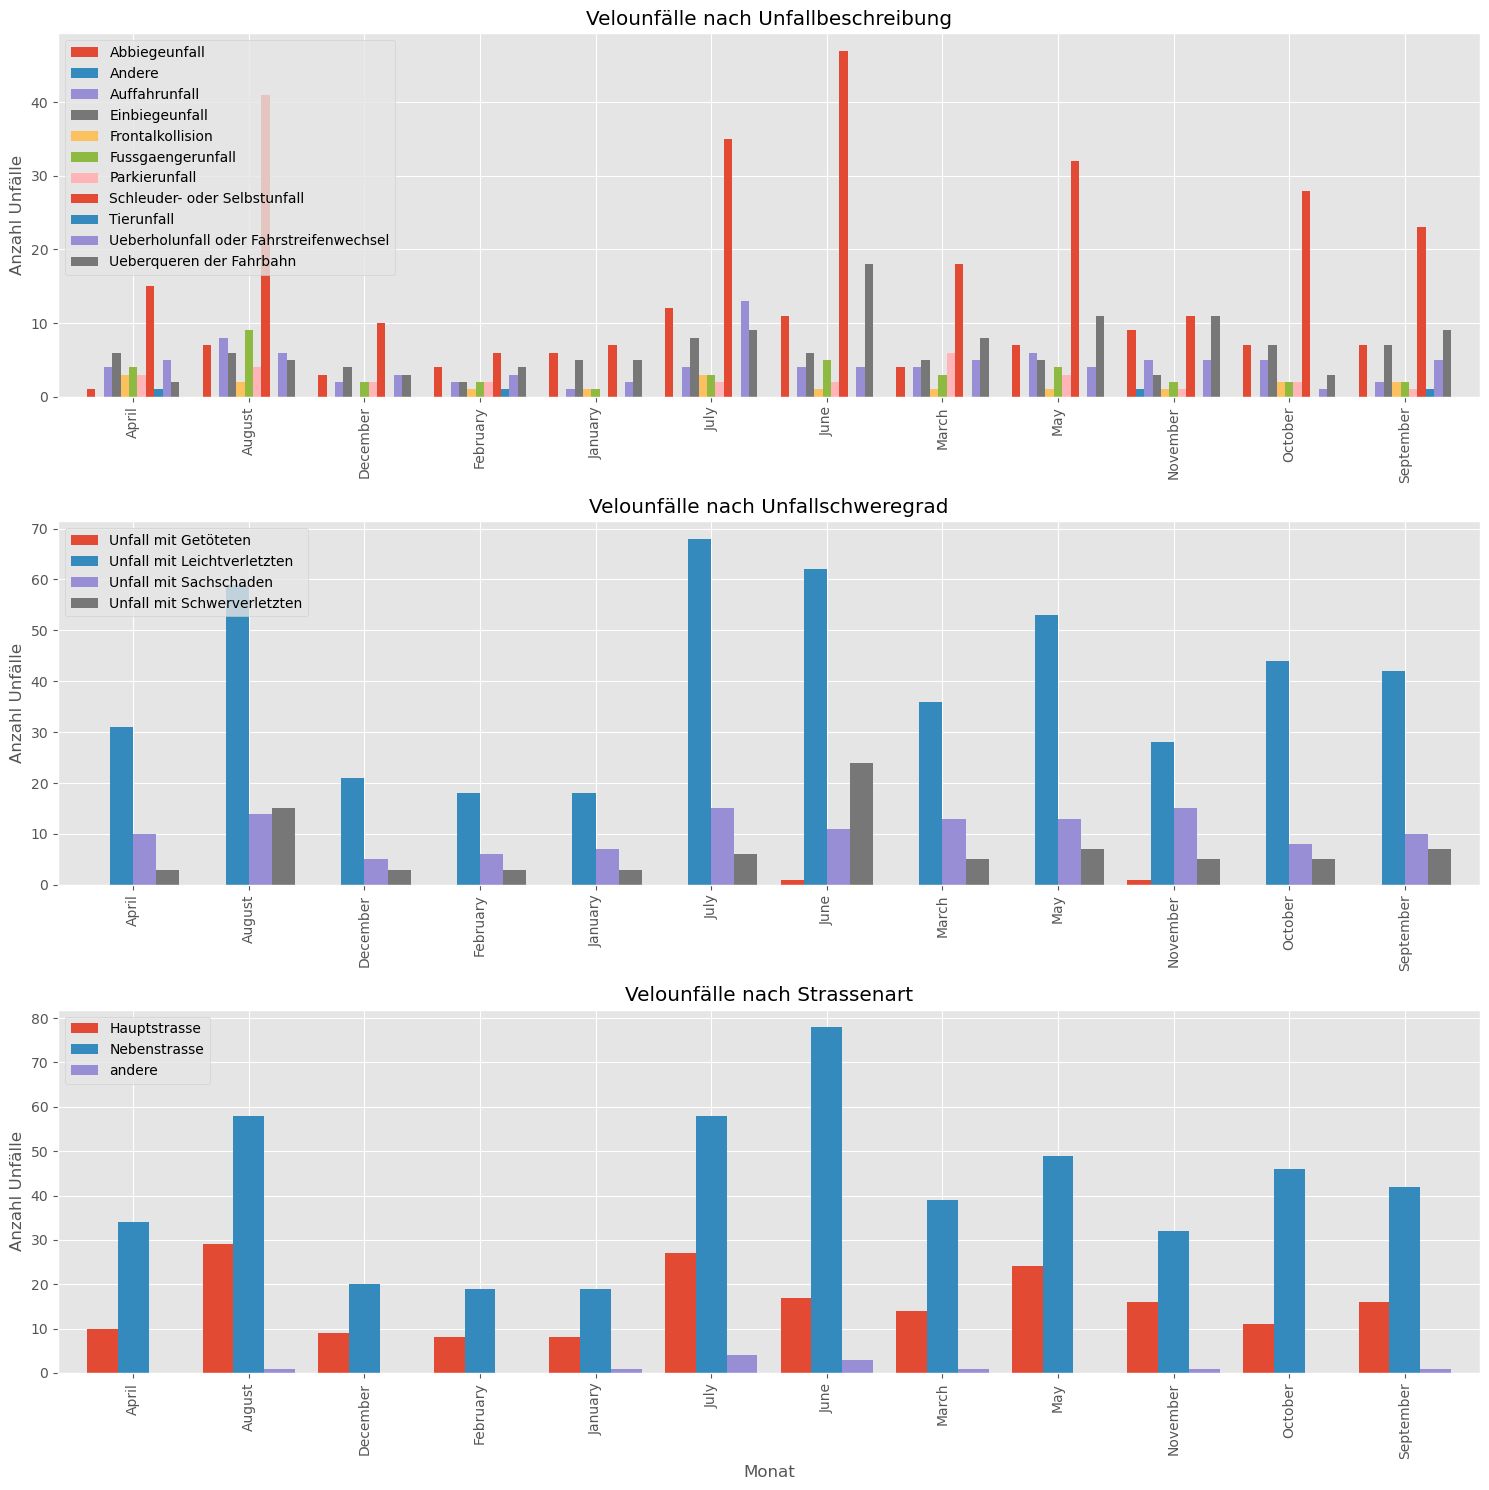

In [41]:
matplotlib.style.use('ggplot')
fig, axarr = plt.subplots(3, 1, figsize=(15, 15))

gb_expl.pivot_table(index='month_name', columns='AccidentExpl', values='size').fillna(0.0).plot.bar(ax=axarr[0], width=0.8)
gb_cat.pivot_table(index='month_name', columns='AccidentSeverityCategory', values='size').fillna(0.0).plot.bar(ax=axarr[1], width=0.8)
gb_road.pivot_table(index='month_name', columns='RoadType', values='size').fillna(0.0).plot.bar(ax=axarr[2], width=0.8)

axarr[0].set_title('Velounfälle nach Unfallbeschreibung')
axarr[0].set(xlabel=None, ylabel='Anzahl Unfälle')
axarr[0].legend(loc='upper left')

axarr[1].set_title('Velounfälle nach Unfallschweregrad')
axarr[1].set(xlabel=None, ylabel='Anzahl Unfälle')
axarr[1].legend(loc='upper left')

axarr[2].set_title('Velounfälle nach Strassenart')
axarr[2].set(xlabel='Monat', ylabel='Anzahl Unfälle')
axarr[2].legend(loc='upper left')

plt.tight_layout()
plt.savefig('./Image/unfallanalyse_zh.png', bbox_inches='tight')
plt.show()

***
# Zunahme der Velounfälle nach Unfallkategorie und Monat

In diesem Abschnitt wird ein Bar chart race erstellt. Aufgrund der Datengrösse ist die Ausführung zeitlich aufwändig. Der folgende Abschnitt wird einmal ausgeführt, damit das mp4 File erstellt und lokal gespeichert werden kann. Im zweiten Schritt wird dann das mp4 File implementiert, damit es abgespielt werden kann. Dieser Abschnitt wird deshalb auskomentiert bleiben.

In [42]:
# Kernel neustarten damit matplotlib 3.2.2 installiert werden kann
restartkernel()

### Installation notwenidger Bibliotheken

In [43]:
!pip install bar_chart_race
!pip install ffmpeg-python
# !pip install --user matplotlib==3.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 3.8 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492025 sha256=06f87f44c83b0b54b8b3155d9e693804f8777430d5219a4437805e0dd4cf3f42
  Stored in directory: /home/jovyan/.cache/pip/wheels/5e/a9/47/f118e66afd12240e4662752cc22cefae5d97275623aa8ef57d
Successfully built future


### Module importieren

In [44]:
#import pandas as pd
import calendar
import bar_chart_race as bcr
#import matplotlib
from IPython.display import Video

In [45]:
import warnings
warnings.filterwarnings("ignore")

### Bar chart race erstellen

In [46]:
df_unfaelle = pd.read_csv('./Daten/velounfaelle_2019_ZH.csv',sep=';')

In [47]:
df_unfaelle.columns

Index(['AccidentExpl', 'AccidentSeverityCategory',
       'AccidentInvolvingPedestrian', 'AccidentInvolvingBicycle',
       'AccidentInvolvingMotorcycle', 'RoadType', 'AccidentYear',
       'AccidentMonth', 'AccidentWeekDay', 'AccidentHour', 'Latidute_wgs84',
       'Longitude_wgs84', 'geometry'],
      dtype='object')

In [48]:
# Spalte mit Monatsnamen erstellen
df_unfaelle['month_name'] = df_unfaelle['AccidentMonth'].apply(lambda x: calendar.month_name[x])

In [49]:
# Sliced Dataframe mit Unfallbeschreibung und Monat
df_unfaelle_kat = df_unfaelle[['AccidentExpl', 'month_name']]

Letzter Zugriff: 30.11.2021 https://stackoverflow.com/questions/40900195/pandas-cumulative-count 

In [50]:
# Get the cumulative counts.
counts = pd.get_dummies(df_unfaelle_kat['AccidentExpl']).cumsum()

# Rename the count columns as appropriate.
counts = counts.rename(columns=lambda col: col)

# Join the counts to the original df.
df_unfaelle_kat = df_unfaelle_kat.join(counts)

In [51]:
df_unfaelle_kat = df_unfaelle_kat.set_index('month_name')

In [52]:
df_unfaelle_kat = df_unfaelle_kat.drop('AccidentExpl', axis=1)

Letzter Zugriff: 30.11.2021 https://www.dexplo.org/bar_chart_race/

Takes a lot of time to create the video!!!

In [53]:
#UserWarning suppresed: FixedFormatter warning
#bcr.bar_chart_race(df=df_unfaelle_kat,
#                   filename='./Image/zunahme_unfaelle_pro_kat.mp4',
#                   title='Zunahme Velounfälle nach Unfallkategorie und Monat',
#                   figsize=(5, 3), 
#                   dpi=144,
#                   steps_per_period=20,
#                   bar_label_size=7,
#                   tick_label_size=4)

In [54]:
Video('./Image/zunahme_unfaelle_pro_kat.mp4')

***
## Darstellung der häufigsten Unfallorte

In der nachfolgenden Darstellung soll gezeigt werden, wo die häufigsten Unfallorte sind und in welche Kategorie diese Fallen. Mit einer Interaktiven Karte
kann ausgewählt werden, welche Unfallarten angezeigt werden sollen.

Die Daten werden aus den vorher erstellten CSV Dateien geladen und in ein Geopandas Dataframe umgewandelt.

In [55]:
df_unfaelle= pd.read_csv('./Daten/velounfaelle_2019_ZH.csv',sep=';')
df_unfaelle['geometry'] = df_unfaelle['geometry'].apply(wkt.loads)
gdf_unfaelle=gpd.GeoDataFrame(df_unfaelle,geometry='geometry')
gdf_unfaelle.head(4)

AccidentExpl     AccidentSeverityCategory  \
0          Frontalkollision       Unfall mit Sachschaden   
1            Einbiegeunfall  Unfall mit Leichtverletzten   
2  Ueberqueren der Fahrbahn       Unfall mit Sachschaden   
3             Abbiegeunfall       Unfall mit Sachschaden   

   AccidentInvolvingPedestrian  AccidentInvolvingBicycle  \
0                        False                      True   
1                        False                      True   
2                        False                      True   
3                        False                      True   

   AccidentInvolvingMotorcycle      RoadType  AccidentYear  AccidentMonth  \
0                        False  Nebenstrasse          2019              1   
1                        False  Nebenstrasse          2019              1   
2                        False  Hauptstrasse          2019              1   
3                        False  Nebenstrasse          2019              1   

  AccidentWeekDay  AccidentHour  Latidute_wgs84  Longitude_wgs84  \
0         Freitag            13       47.375761         8.529004   
1          Montag             6       47.373162         8.503925   
2          Montag            18       47.365288         8.521601   
3        Dienstag             7       47.375884         8.527405   

                   geometry  
0  POINT (8.52901 47.37576)  
1  POINT (8.50393 47.37317)  
2  POINT (8.52160 47.36529)  
3  POINT (8.52741 47.37589)

Anschliessend werden sie mithilfe von Folium dargestellt.

In [56]:
# Koordinaten von ZH ermitteln und folium.Map hinzufügen
koor_zh = koordinaten_zh()
m=folium.Map(location=[koor_zh[0],koor_zh[1]],zoom_start=12)
cluster=MarkerCluster()

for i in gdf_unfaelle.AccidentSeverityCategory.unique():
    df=gdf_unfaelle.loc[gdf_unfaelle.AccidentSeverityCategory==i]
    locations=list(zip(df.Latidute_wgs84,df.Longitude_wgs84,))
    marker_cluster=MarkerCluster(locations,name=i).add_to(m)
folium.LayerControl().add_to(m)

# for loc,popup in zip(locations,df_unfaelle.AccidentSeverityCategory):
#     folium.Marker(loc,popup=popup,icon=folium.Icon(icon='info_sign')).add_to(cluster)
#     marker_cluster.add_to(m)
    #folium.LayerControl(show=True).add_to(m)

m.save('./Image/hauf_unfaelle.html')
display(m)

***
## Ist das Velonetz ausreichend ausgebaut an diesen Orten?

Hier soll analysiert werden, ob das Velonetz ausreichend asugebaut ist und ob Teile der Unfälle aussheralb des ausgebauten <br>
Netzes auftraten. Es soll Aufschluss geben, ob es notwendig ist das Velonetzwerk weiter zu vergrössern, oder ob die bereits genutzten Fahrradwege <br>
mehr Sicherheit benötigen. <br><br>
Diese Ergebnisse können interaktiv aus der Karte gelesen werden und sind näher in der Dokumentation beschrieben.

In [57]:
df_netz= pd.read_csv('./Daten/routennetz_ZH.csv',sep=';')
df_netz['geometry'] = df_netz['geometry'].apply(wkt.loads)
gdf_netz=gpd.GeoDataFrame(df_netz,geometry='geometry')
gdf_netz.crs='EPSG:4326'
gdf_netz.head(4)

velo velostreifen  veloweg einbahn  fuss                              name  \
0     0            0        0       0     1  Bahnhof Oerlikon, Perron Gleis 6   
1     0            0        0       0     0                    Bahnhofstrasse   
2     1            0        0       0     0                   Zwischenbaechen   
3     1            0        0       0     0                Schanzackerstrasse   

   map_velo  map_fuss                                           geometry  
0         0         0    LINESTRING (8.54406 47.41199, 8.54443 47.41212)  
1         0         0  LINESTRING (8.53985 47.37686, 8.53986 47.37688...  
2         1         0    LINESTRING (8.48085 47.38451, 8.48058 47.38413)  
3         0         0  LINESTRING (8.54727 47.39015, 8.54757 47.39119...

In [58]:
# Koordinaten von ZH ermitteln und folium.Map hinzufügen
koor_zh = koordinaten_zh()
m=folium.Map(location=[koor_zh[0],koor_zh[1]],zoom_start=12)

colors=['darkgreen','blue','orange','red']

folium.Choropleth(gdf_netz[gdf_netz.velostreifen!='0'],line_color='blue',line_weight=5,line_opacity=0.3,name='Velostreifen').add_to(m)
folium.Choropleth(gdf_netz[gdf_netz.veloweg!=0].geometry,line_color='red',line_weight=5,line_opacity=0.3,name='Veloweg').add_to(m)

for i,k in zip(gdf_unfaelle.AccidentSeverityCategory.unique(),colors):
    #print(i,k)
    cluster=MarkerCluster(name=i)
    df=gdf_unfaelle.loc[gdf_unfaelle.AccidentSeverityCategory==i]
    locations=list(zip(df.Latidute_wgs84,df.Longitude_wgs84))

    if k=='red':
        icon='remove'
    else:
        icon='minus'

    for l in locations:
        x=folium.Marker(l,icon=folium.Icon(icon_color='white',color=k,icon=icon),popup=i).add_to(cluster)

    cluster.add_to(m)   
folium.LayerControl().add_to(m)

m.save('./Image/velonetz.html')
display(m)

***
## Wo fahren die meisten Velos

Anhand der Velozaehlungsdaten, welche aus dem vorher erstellten CSV File gelesen werden, soll analysiert werden, an welcher Stelle die meisten Velos passieren. <br>
Dies soll dann in die interaktive Karte der Unfälle und des Velonetzes aufgenommen werden und informieren, ob es viele Unfälle an Stellen gibt, an denen <br>
viele Velos verkehren, oder ob die Unfallorte im Endeffekt unabhängig sind von der Anzahl Velos.

In [59]:
df_zaehlung= pd.read_csv('./Daten/verkehrszaehlung_2019_ZH.csv',sep=';')
df_zaehlung1=df_zaehlung.groupby(['zaehler','Latidute_wgs84','Longitude_wgs84']).sum().reset_index()

In [60]:
df_zaehlung1['velo_ges']=df_zaehlung1.velo_in+df_zaehlung1.velo_out
df_zaehlung1=df_zaehlung1.sort_values(by=['velo_ges'],ascending=False)[0:5]
df_zaehlung1

zaehler  Latidute_wgs84  Longitude_wgs84   standort   velo_in  \
50  Y2H16039396       47.380489         8.528426  114822803  886638.0   
52  Y2H16069943       47.383630         8.515815   36335443  552895.0   
54  Y2H18106793       47.380617         8.528190   69396921  253002.0   
16  ECO09113503       47.369183         8.529241  112242096  291883.0   
53  Y2H18106792       47.364580         8.550740  126070322  261413.0   

    velo_out  fuss_in  fuss_out      year   month     day    hour  minute  \
50  275725.0      0.0       0.0  70743741  228690  550805  402958  788400   
52  317573.0      0.0       0.0  70743741  228690  550805  402958  788400   
54  488364.0      0.0       0.0  38952567   89758  310179  221896  434070   
16  356622.0      0.0       0.0  57751476  218004  460676  328984  643590   
53  267028.0      0.0       0.0  70743741  228690  550805  402958  788400   

     velo_ges  
50  1162363.0  
52   870468.0  
54   741366.0  
16   648505.0  
53   528441.0

In [61]:
# Koordinaten von ZH ermitteln und folium.Map hinzufüge
koor_zh = koordinaten_zh()
m=folium.Map(location=[koor_zh[0],koor_zh[1]],zoom_start=12)
stand=folium.FeatureGroup(name='Standorte mit meisten Velos').add_to(m)

for lat, lng, label, anz in zip(df_zaehlung1.Latidute_wgs84, df_zaehlung1.Longitude_wgs84, df_zaehlung1.standort,df_zaehlung1.velo_ges):

    folium.Marker(
        location=[lat, lng],
        icon=folium.Icon(color='green',icon='flag'),
        popup='Standort: '+str(label)+', Anzahl: '+str(anz),
        name='Standorte'
    ).add_to(stand)
    

colors=['darkgreen','blue','orange','red']

folium.Choropleth(gdf_netz[gdf_netz.velostreifen!='0'],line_color='blue',line_weight=5,line_opacity=0.3,name='Velostreifen').add_to(m)
folium.Choropleth(gdf_netz[gdf_netz.veloweg!=0].geometry,line_color='red',line_weight=5,line_opacity=0.3,name='Veloweg').add_to(m)

for i,k in zip(gdf_unfaelle.AccidentSeverityCategory.unique(),colors):
    #print(i,k)
    cluster=MarkerCluster(name=i)
    df=gdf_unfaelle.loc[gdf_unfaelle.AccidentSeverityCategory==i]
    locations=list(zip(df.Latidute_wgs84,df.Longitude_wgs84))

    if k=='red':
        icon='remove'
    else:
        icon='minus'

    for l in locations:
        x=folium.Marker(l,icon=folium.Icon(icon_color='white',color=k,icon=icon),popup=i).add_to(cluster)

    cluster.add_to(m)   
folium.LayerControl(collapsed=False).add_to(m)

m.save('./Image/velozaehlung.html')
display(m)

***
## Anzahl der Unfälle pro gezählten Velos pro Monat

Im vorherigen Abschnitt wurde bereits analysiert, wieviele Unfälle pro Monat auftreten. Es ist allerdings logisch, dass in den wärmeren Monaten (April-September) <br>
auch mehr Fahrradfahrer auf den Strassen sind und dadurch auch mehr Unfälle geschehen werden. Aber wie ist es, wenn man die Anzahl der gezählten Velos in einem Monat, zu der Anzahl <br>
an Unfällen in einem Monat in Relation stellt?

Es werden sowohl die Daten der Zählung als auchd er Unfälle eingelsen und transformiert.

In [62]:
df_zaehlung= pd.read_csv('./Daten/verkehrszaehlung_2019_ZH.csv',sep=';')
df_unfaelle=pd.read_csv('./Daten/velounfaelle_2019_ZH.csv',sep=';')

Die Unfälle und Zählung wird gruppiert und aufsummiert, bzw. gezählt.

In [63]:
df_zaehlung.head()
df_zahl=df_zaehlung.groupby('month').sum().reset_index()
df_zahl['ges_velos']=df_zahl.velo_in+df_zahl.velo_out
df_zahl

df_unf=df_unfaelle.groupby('AccidentMonth').count().reset_index()

df_unf['unf_pro_10000']=df_unf.AccidentExpl/df_zahl.ges_velos*10000
df_unf

AccidentMonth  AccidentExpl  AccidentSeverityCategory  \
0               1            28                        28   
1               2            27                        27   
2               3            54                        54   
3               4            44                        44   
4               5            73                        73   
5               6            98                        98   
6               7            89                        89   
7               8            88                        88   
8               9            59                        59   
9              10            57                        57   
10             11            49                        49   
11             12            29                        29   

    AccidentInvolvingPedestrian  AccidentInvolvingBicycle  \
0                            28                        28   
1                            27                        27   
2                            54                        54   
3                            44                        44   
4                            73                        73   
5                            98                        98   
6                            89                        89   
7                            88                        88   
8                            59                        59   
9                            57                        57   
10                           49                        49   
11                           29                        29   

    AccidentInvolvingMotorcycle  RoadType  AccidentYear  AccidentWeekDay  \
0                            28        28            28               28   
1                            27        27            27               27   
2                            54        54            54               54   
3                            44        44            44               44   
4                            73        73            73               73   
5                            98        98            98               98   
6                            89        89            89               89   
7                            88        88            88               88   
8                            59        59            59               59   
9                            57        57            57               57   
10                           49        49            49               49   
11                           29        29            29               29   

    AccidentHour  Latidute_wgs84  Longitude_wgs84  geometry  unf_pro_10000  
0             28              28               28        28       0.631238  
1             27              27               27        27       0.493609  
2             54              54               54        54       0.770558  
3             44              44               44        44       0.598798  
4             73              73               73        73       0.836352  
5             98              98               98        98       1.000305  
6             89              89               89        89       0.983470  
7             88              88               88        88       0.938193  
8             59              59               59        59       0.620665  
9             57              57               57        57       0.726305  
10            49              49               49        49       0.709281  
11            29              29               29        29       0.535105

Letzter Zugriff: 30.11.2021 https://matplotlib.org/stable/gallery/lines_bars_and_markers/hat_graph.html#sphx-glr-gallery-lines-bars-and-markers-hat-graph-py

In [1]:
matplotlib.style.use('ggplot')

months = ['January','February','March','April','May','June','July','August','September','October','November','December']

# Unfälle nach Monat gruppieren
fig = df_unf.plot.bar(y='unf_pro_10000',x = 'AccidentMonth',figsize = (20,8), width = 0.9,color='blue')
plt.rcParams.update({'font.size': 20})

ax = fig.axes # main axes
ax.set_xticklabels(months)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
    
for p in ax.patches:                 
    ax.annotate(np.round(p.get_height(),decimals=2),                             
    (p.get_x() + p.get_width() / 2, p.get_height()),                              
    ha='center',                              
    va='center',                              
    xytext=(0, 10),                               
    textcoords='offset points')

plt.xlabel('Monat', fontsize=18)
plt.ylabel('Anzahl Unfälle', fontsize=18)
plt.title('Anzahl Unfälle pro Monat pro 10000 gezählte Velos im Jahr 2019', loc='left', fontsize=18)
leg = ax.legend(prop={"size":16})
ax.get_legend().remove()

plt.savefig('./Image/unfaelle_velozaeh_zh.png', bbox_inches='tight')
plt.show()

NameError: name 'matplotlib' is not defined

Anhand dieser Grafik wird deutlich, dass zwar immer noch die meisten Unfälle im Sommer geschehen, was vermutlich an der erhöhten Frequenz an Velofahrern liegt, so wie der Tatsache, dass die Leute auch spät am Abend mit dem Fahrrad fahren und etwas unachtsamer sind. Trotzdem soll hier darauf hingeweisen werden, dass auch in den Wintermonaten und zB. den Uebergangsmonaten
eine grössere Anzahl an Unfällen aufgezeichnet wurde. Diese könnten durch Unachtsamkeiten auftreten, sowie dem Unterschätzen des Wetters (Glatteisbildung) und anderen Faktoren, die durch as Wetter beiflussbar sind.